<a href="https://colab.research.google.com/github/asifa1510/LNN/blob/main/lnn_implementation_fp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from math import tanh,sin,pi
import random
import matplotlib.pyplot as plt
def zeros(n): return [0.0]*n
def mat_zeros(r,c): return [[0.0]*c for _ in range(r)]
def matvec(W,x): return [sum(wij*xj for wij,xj in zip(row,x)) for row in W]

In [19]:
class LTCCell:
    def __init__(self, N, M, seed=0, init_scale=0.5):
        random.seed(seed)
        self.N, self.M = N, M
        self.W_rec = mat_zeros(N, N)
        self.W_in  = mat_zeros(N, M)
        self.b     = [random.uniform(-init_scale, init_scale) for _ in range(N)]
        self.tau   = [0.8 + 0.4*random.random() for _ in range(N)]
        self.A     = [random.uniform(-0.5, 0.5) for _ in range(N)]
        self.W_out = [[random.uniform(-init_scale, init_scale) for _ in range(N)]]
        self.b_out = [random.uniform(-init_scale, init_scale)]
        for i in range(N):
            for j in range(N):
                self.W_rec[i][j] = random.uniform(-init_scale, init_scale)
            for m in range(M):
                self.W_in[i][m] = random.uniform(-init_scale, init_scale)

    def step(self, x, u, dt):
        pre = [0.0]*self.N
        for i in range(self.N):
            pre[i] = sum(self.W_rec[i][j]*x[j] for j in range(self.N)) \
                   + sum(self.W_in[i][m]*u[m] for m in range(self.M)) \
                   + self.b[i]
        f = [tanh(p) for p in pre]
        q = [1.0 + dt*(1.0/self.tau[i] + f[i]) for i in range(self.N)]
        x_next = [x[i] + dt*f[i]*self.A[i]/q[i] for i in range(self.N)]
        y = sum(self.W_out[0][j]*x_next[j] for j in range(self.N)) + self.b_out[0]
        return x_next, y, pre, f, q

    def run(self, x0, inputs, dt):
        x = x0[:]
        X = [x[:]]; Y = []; PRE=[]; F=[]; Q=[]
        for u in inputs:
            x, y, pre, f, q = self.step(x, u, dt)
            X.append(x[:]); Y.append(y); PRE.append(pre); F.append(f); Q.append(q)
        return X, Y, PRE, F, Q


Initial MSE: 0.533291


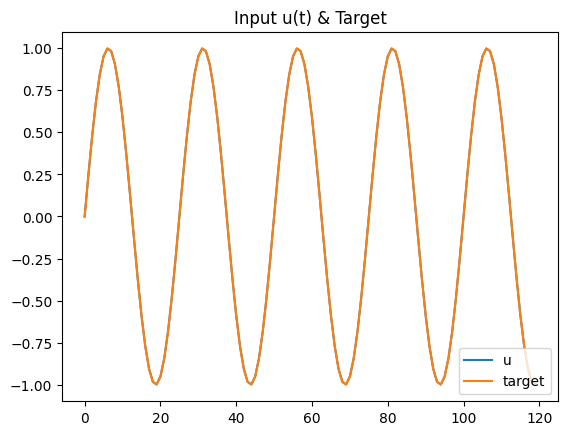

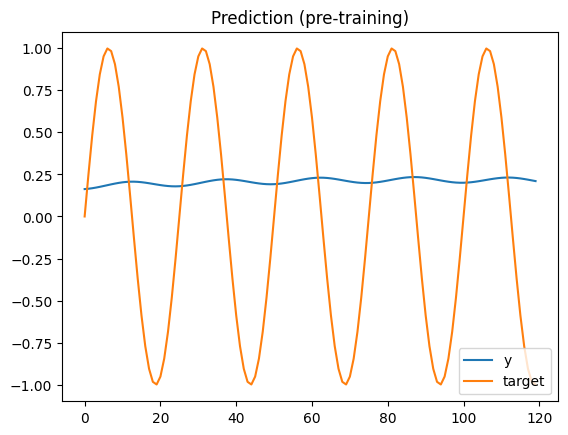

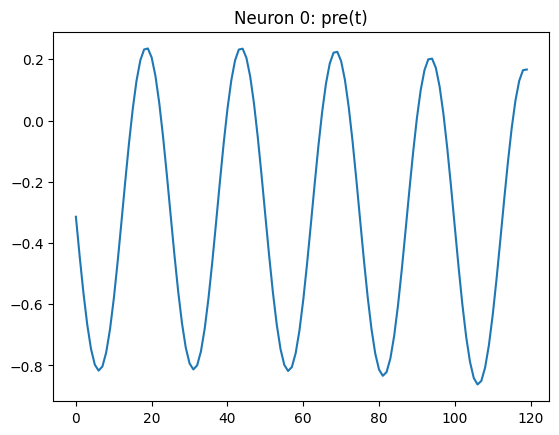

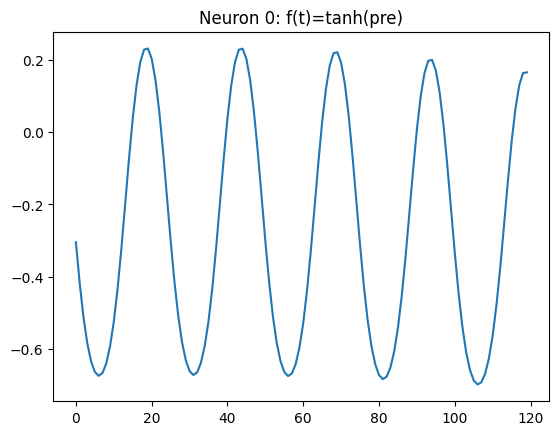

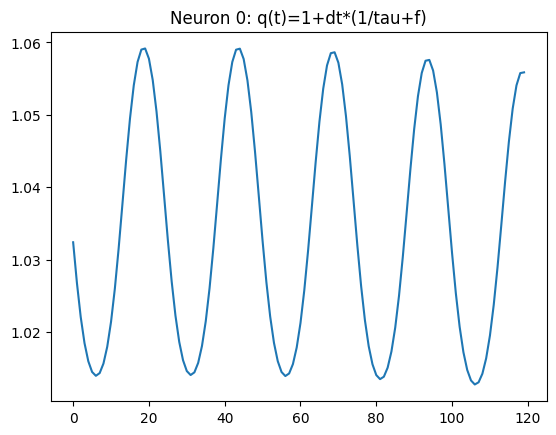

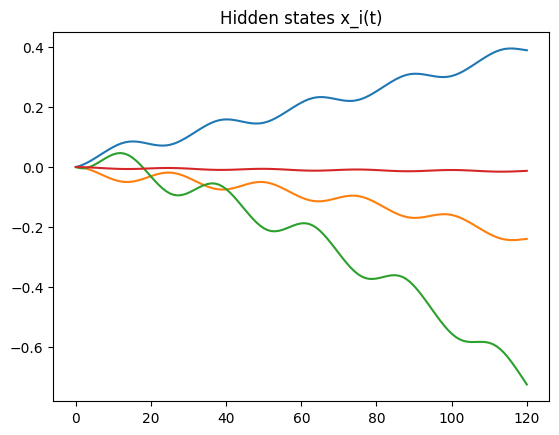

In [20]:
T, dt = 120, 0.05
inputs  = [[sin(2*pi*t/25.0)] for t in range(T)]
targets = [u[0] for u in inputs]

N, M = 4, 1
cell = LTCCell(N, M, seed=3, init_scale=0.6)
x0 = zeros(N)

X, Y, PRE, F, Q = cell.run(x0, inputs, dt)
mse0 = sum((yi-ti)**2 for yi,ti in zip(Y,targets))/len(Y)
print("Initial MSE:", round(mse0, 6))

plt.figure(); plt.title("Input u(t) & Target"); plt.plot([u[0] for u in inputs], label="u")
plt.plot(targets, label="target"); plt.legend(); plt.show()

plt.figure(); plt.title("Prediction (pre-training)"); plt.plot(Y, label="y"); plt.plot(targets, label="target")
plt.legend(); plt.show()

plt.figure(); plt.title("Neuron 0: pre(t)"); plt.plot([p[0] for p in PRE]); plt.show()
plt.figure(); plt.title("Neuron 0: f(t)=tanh(pre)"); plt.plot([f[0] for f in F]); plt.show()
plt.figure(); plt.title("Neuron 0: q(t)=1+dt*(1/tau+f)"); plt.plot([q[0] for q in Q]); plt.show()

xs = list(zip(*X))
plt.figure(); plt.title("Hidden states x_i(t)");
for i in range(N): plt.plot(xs[i])
plt.show()


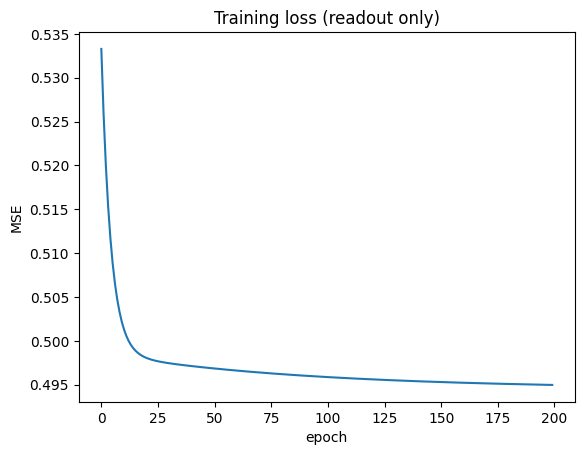

In [21]:
def train_readout(cell, X, targets, lr=5e-2, epochs=200):
    N = cell.N
    X_seq = X[1:]
    losses = []
    for e in range(epochs):
        Y = [sum(cell.W_out[0][j]*x[j] for j in range(N)) + cell.b_out[0] for x in X_seq]
        diffs = [y - t for y, t in zip(Y, targets)]
        Tlen = len(Y)
        gW = [(2.0/Tlen)*sum(diffs[t]*X_seq[t][j] for t in range(Tlen)) for j in range(N)]
        gb = (2.0/Tlen)*sum(diffs)
        for j in range(N): cell.W_out[0][j] -= lr * gW[j]
        cell.b_out[0] -= lr * gb
        losses.append(sum(d*d for d in diffs)/Tlen)
    return losses

losses = train_readout(cell, X, targets, lr=5e-2, epochs=200)

plt.figure(); plt.title("Training loss (readout only)"); plt.plot(losses); plt.xlabel("epoch"); plt.ylabel("MSE"); plt.show()


Final MSE: 0.494975


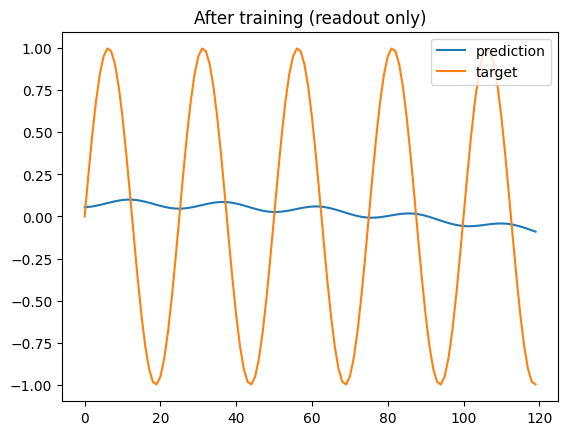

In [22]:
X2, Y2, *_ = cell.run(x0, inputs, dt)
mseF = sum((yi-ti)**2 for yi,ti in zip(Y2,targets))/len(Y2)
print("Final MSE:", round(mseF, 6))

plt.figure(); plt.title("After training (readout only)")
plt.plot(Y2, label="prediction"); plt.plot(targets, label="target"); plt.legend(); plt.show()
